# Task 2
- open image I
- crop subimage J
- ...

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from PIL import Image
from scipy.spatial.distance import hamming
from matplotlib.patches import Rectangle
import io
from Crypto.Cipher import AES

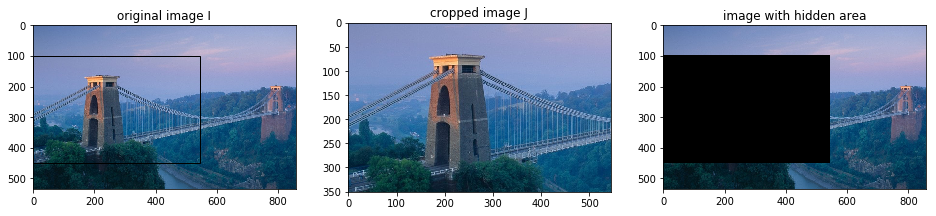

In [3]:
I = np.array(Image.open('bridge.png'))

x, y = 0, 100
w, h = 545, 351

# patch = (100, 200, 500, 300) # upper left, bottom right

J = Image.fromarray(I[y:y+h, x:x+w])

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(131)
ax1.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black'))
ax1.set_title('original image I')
ax1.imshow(I)

ax2 = fig.add_subplot(132)
ax2.imshow(J)
ax2.set_title('cropped image J')

# I[y:y+h, x:x+w] = 0 # black area
I[y:y+h, x:x+w] = 0 # black patch
ax3 = fig.add_subplot(133)
ax3.set_title('image with hidden area')
ax3.imshow(I)

In [4]:
# compress cropped image J
J_compressed = io.BytesIO()
J.save(J_compressed, format='PNG', compress_level=9) # maximum compression, slowest time (1-9)
message = J_compressed.getvalue()
print(message[:100])

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02!\x00\x00\x01_\x08\x02\x00\x00\x00\x17\xb5\x8b\xfc\x00\x01\x00\x00IDATx\xda\xac\xfdY\xb3$I\x96\x1e\x88\x9dsTmq\xf7\xbb\xc5\x96\x91\x99\x11\xb9WUV\xd7\xd2U\xe8n4\xba0\x00\x1a\x83\x91\x16\x8c4D(\x84\x08\x85B>P\xf8\x03\xf8\x07\xf8BP\xe6\x91'


In [5]:
# encrypt the message
cipher = AES.new('This is a secret key1234', AES.MODE_ECB, 'This is an IV456') # never use ECB in strong systems
padding = 16 * (len(message) // 16 + 1)
encrypted = cipher.encrypt(message.rjust(padding))
print(encrypted[:100])
# decrypted = cipher.decrypt(encrypted)
# print(decrypted.strip() == message)

b'\xd8\xd7K\xa0\xe2\x93\xc4\x86\xc6\x81[\xb6\x06\x96\x8a\xd5\\\xb6\x94\xd3`\xbc\xcc&\xc8G>rI\x96o\xb5\xe4\x83\x98\xbf\xad?)\x95a\x8cV\xa5\x1f%\x9e~\x08\x1f\xaey~\xfd\x1f\xde\x0e`\xd7\x0e@\x1biw\x11@\xc7/!}\xf2\x19\x1aII\x81qNz\x9bEG\x97%P\xce\xb8\xf2r\x13=p!\xc0o\xd4n\xdb\xed\xc4'


In [6]:
def insert(image, message, x, y, w, h):
    '''
    Insert a message in image using LSB method
    key now is shift from begining of image
    '''    
    image = np.array(image)
    print('patch/image =', w*h/image.shape[0]/image.shape[1])
    print('message length={}'.format(len(message)))
    if len(message) > image.shape[0] * image.shape[1] - w*h:
        print('error: too big message to insert')
    
    k = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not (i >= y and i < y+h and j >= x and j < x+w): # check that we're not inside patch
                if k == len(message):
                    return Image.fromarray(image)
                byte = message[k]
                k += 1
                image[i][j][0] = int(format(image[i][j][0], '#010b')[:-3] + format(byte, '#010b')[2:5], base=2) # write to last 3 bits of red
                image[i][j][1] = int(format(image[i][j][1], '#010b')[:-3] + format(byte, '#010b')[5:8], base=2) # write to last 3 bits of green
                image[i][j][2] = int(format(image[i][j][2], '#010b')[:-2] + format(byte, '#010b')[8:10], base=2) # write to last 2 bits of blue

        
def extract(image, msg_len, x, y, w, h):
    image = np.array(image)
    message = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not (i >= y and i < y+h and j >= x and j < x+w): # check that we're not inside patch
                if len(message) == msg_len:
                    return bytes(message)
                pixel_bits = format(image[i][j][0], '#010b')[-3:] + \
                             format(image[i][j][1], '#010b')[-3:] + \
                             format(image[i][j][2], '#010b')[-2:]
                message.append(int(pixel_bits, base=2))
                
#                 print(k)

patch/image = 0.41595997286295794
message length=268496
True


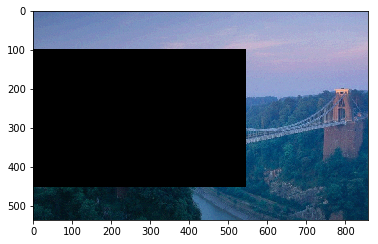

In [7]:
I_with_message = insert(I, encrypted,x,y,w,h)
m = extract(I_with_message, len(encrypted), x,y,w,h)
plt.imshow(I_with_message)
print(m == encrypted)

decrypted == message: True
J == K: True


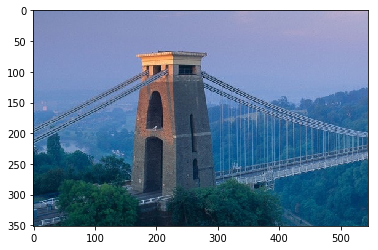

In [8]:
decrypted = cipher.decrypt(m).strip()
print('decrypted == message:', decrypted == message)
J2 = np.array(Image.open(io.BytesIO(decrypted)))
plt.imshow(J2)
print('J == K:', np.array_equal(J, J2))

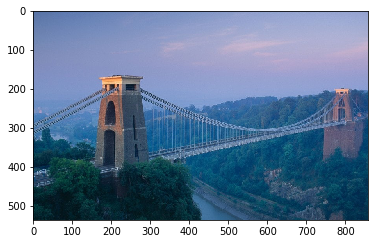

In [10]:
I[y:y+h, x:x+w] = J2
plt.imshow(I)
I = Image.fromarray(I)
I.save('2.png')